In [1]:
from tqdm.notebook import tqdm

In [2]:
import tensorflow as tf; print(tf.__version__)

2.3.0


In [3]:
#Importing GIS Software 
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.notebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg
from gis_utils import raster
import matplotlib.pyplot as plt
import fiona
import numpy as np
import pandas as pd

# Image Generation Functions


In [4]:
def write_ndvi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    nir = p_img.read(4)
    array = p_img.read()
    ndvi = (nir - red)/(nir + red)
    show(ndvi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndvi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [5]:
def write_ndwi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    green = p_img.read(2)
    nir = p_img.read(4)
    array = p_img.read()
    ndwi = (green - nir)/(nir + green)
    show(ndwi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndwi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [6]:
def write_vari(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    green = p_img.read(2)
    blue = p_img.read(3)
    array = p_img.read()
    vari = (green - red)/(green + red - blue)
    show(vari)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(vari, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [7]:
#getting features from the gdf for rasterio
from os.path import join

def getFeatures(gdf):

    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
          

In [8]:
#for creating corresponding HR tiles from LR pixels
def transfer_tiles(img, meta, tile_path, output_path):
    out_meta = meta
    output_filename = 'hr_{}.tif'
    d_bbox = box(img.bounds.left, img.bounds.bottom, img.bounds.right, img.bounds.top)

    for root, dirs, files in os.walk(tile_path):
        for file in tqdm(files):
            name = os.path.splitext(file)[0]
            dataset, _ = raster.load_image(join(root,file))
            bounds = dataset.bounds
            bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

            if bbox.within(d_bbox):
                geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
                geo = geo.to_crs(crs=dataset.crs.data)
                coords = getFeatures(geo)
                out_img, out_transform = mask(img, shapes=coords, crop=True)
                out_meta.update({"driver": "GTiff","height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": from_epsg(4326)})
                outpath = os.path.join(output_path, output_filename.format(name))
                with rasterio.open(outpath, 'w', **out_meta) as outds:
                    outds.write(out_img)
            

In [9]:
#for removing tiles created 
def remove_zero(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, meta = raster.load_image(filepath)
        if np.array_equal(np.unique(np.array(tile.read())), [0.]):
            os.remove(filepath)

# Workflow Functions

In [10]:
#Function for getting files needed for data generation process from the drive

from os.path import join
from os.path import splitext
def get_filelist():
    cur = []

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    root = os.getcwd()
    print(root)
    for file in os.listdir(root):
        
        #finding all normal tifs
        if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("kompsat" in file) or ("planetscope" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
            #detecting planetscope images
            base = file.split("_120m_RGB")[0]
            for ortho in os.listdir(root):
                if ("planetscope" in ortho) and (base in ortho):
                    #since we will get dupicates
                    file_list = [join(root,file),
                                 join(root,ortho),
                                 join(root, "hybrid_" + splitext(file)[0] + "_classifications")]
                    if not(file_list in cur):
                        cur.append(file_list)
                           
            #print(file)


    return cur

In [11]:
# for copying files over from google drive to 
def copy_files(file_list):
    print("Copying Files")
    
    !rm -rf content
    !rm -rf content/lr
    !rm -rf content/hr
    !mkdir content
    !mkdir content/lr
    !mkdir content/hr
    
    !cp {"\"" + file_list[0] + "\"" } content/drone.tif
    !cp {"\"" + file_list[1] + "\"" } content/planetscope.tif
    
    

In [12]:
def retile(file_list):
    print("Clipping and pixelizing satellite data")

    !gdal_retile.py -ps 1 1 -targetDir "content/lr" "content/planetscope.tif"
    
    remove_zero("content/lr/")


In [13]:
def gen_drone(file_list):
    print("Generating Drone Data")

    d_img, d_meta = raster.load_image("content/drone.tif")
    
    transfer_tiles(d_img, d_meta, "content/lr", "content/hr")


In [14]:
from tempfile import mkdtemp
from skimage.transform import resize
from os.path import basename, dirname
from rasterio.plot import reshape_as_image
import glob


def load_images(image_dir,n_bands):
    hr_name = join(mkdtemp(), 'hr.memmap')
    lr_name = join(mkdtemp(), 'lr.memmap')

    num_images = len(glob.glob1("content/hr","*.tif"))
    hr_mem = np.memmap(hr_name, dtype='float32', mode='w+', shape=(int(num_images),112,112,3))
    lr_mem = np.memmap(lr_name, dtype='float32', mode='w+', shape=(int(num_images),n_bands))

    index = 0
    file_list = []

    for root, dirs, files in os.walk(image_dir):
        for file in tqdm(files):
            if (file.endswith(".tif")):
                file_path = os.path.join(root, file)
                file_list.append(file_path)

                lr_file = file.replace("hr_", "")
                lr_root = root.replace("hr", "lr")
                lr_path = join(lr_root,lr_file)

                hr_image, _ = raster.load_image(file_path)
                lr_image, _ = raster.load_image(lr_path)
                
                hr_mem[index,:,:,:] = resize(reshape_as_image(hr_image.read()), (112,112,3))
                lr_mem[index,:] = np.squeeze(np.squeeze(reshape_as_image(lr_image.read())))
                index += 1
                
            
    
    return hr_mem, lr_mem, file_list

In [15]:

def clean_tiles(image_dir):
    num = 0

    for root, dirs, files in os.walk(image_dir):
        for file in tqdm(files):
            if (file.endswith(".tif")):
                file_path = os.path.join(root, file)
                hr_image, _ = raster.load_image(file_path)
                if np.array_equal(np.unique(hr_image.read()), [0]):
                    lr_file = file.replace("hr_", "")
                    lr_root = root.replace("hr", "lr")
                    lr_path = join(lr_root,lr_file)
                    os.remove(file_path)
                    os.remove(lr_path)
                    num += 1
            
    print(num)

In [16]:
def classify(model, files, hr, lr):
    predictions = model.predict([lr,hr], batch_size=32)
    print(predictions)
    column_names = ["prediction","p_0","p_1","filename"]
    result_df = pd.DataFrame(columns=column_names)


    #associate filenames and classification for each prediction
    for i,prediction in tqdm(enumerate(predictions)):
        result_df.loc[i,"filename"] = files[i]

        #calculating predictions 
        result_df.loc[i,"p_0"] = prediction[0]
        result_df.loc[i,"p_1"] = prediction[1]
        
        #getting final class prediction
        result_df.loc[i,"prediction"] = np.argmax(prediction)
    return result_df

In [17]:
def move_files(result_df):
    image_directory = "content/hr/"

    dest_folders = []
    #Organize tiles into folders
    for index, row in tqdm(result_df.iterrows()):
        cur_file = row['filename']
        classification = row['prediction'] 

        #set destination folder, and creates the folder if it doesn't exist
        dest_folder = os.path.join(os.path.abspath(image_directory),str(classification))
        dest_folders.append(dest_folder)
        if os.path.exists(dest_folder) == False:
            os.mkdir(dest_folder)
        dest = os.path.join(dest_folder,os.path.basename(cur_file))
    
        #moves file
        src = cur_file
        os.rename(src, dest)

In [18]:
from rasterio.merge import merge

def merge_raster(input_files, output_file):
    images = []
    #get files from file list and load the rasters
    for file in input_files:
        image, meta = raster.load_image(file)
        images.append(image)

    #merge all the rasters together
    array, transform = merge(images)

    #set meta of merged file to the same as the original 
    out_meta = meta.copy()

    #edit meta for merged raster
    out_meta.update({"driver": "GTiff",
                                           "height": array.shape[1],
                                           "width": array.shape[2],
                                           "transform": transform}
                                          )
    
    #write merged raster
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(array)
    dest.close()

In [19]:
from os.path import join
from os.path import isdir

#for returning full path of file instead of local path for listdir
def listpath(dir):
    path_list = []
    for file in os.listdir(dir):
        if not(isdir(join(dir,file))):
            path_list.append(join(dir,file))
    return path_list


In [20]:
def generate_probtiles(result_df):
    print("Generating tiles for probability plot")
    for index, sample in tqdm(result_df.iterrows()):
        #loading original image
        original = os.path.abspath( sample["filename"])
        img = rasterio.open(original)

        #creating new raster mask with pixel values of conditional probability
        mask = sample["p_0"] * np.ones(shape=(img.width, img.height))

        #saving file output to new file
        filename = "prob_" + os.path.basename(sample["filename"])
        output = os.path.abspath(os.path.join(os.path.dirname(sample["filename"]), filename))
        #creates new file with projection of past image
        with rasterio.open(output,'w',driver='GTiff',height=img.height,width=img.width,count=1,dtype=mask.dtype,crs='+proj=latlong',transform=img.transform,) as dst:dst.write(mask, 1)
        dst.close()

In [21]:
def create_rasters(site):
    ds_factor = 1/20

    name = os.path.splitext(os.path.basename(site[0]))[0]
    !mkdir {"\"" + site[2] + "\""}
    
    #create nonmangrove ortho
    one_out = join(site[2], "hybrid_" + name + "_nonmangrove.tif")
    
    list_file = open("tile_list.txt", "w")
    for file in os.listdir("content/hr/1/"):
            if file.endswith(".tif"):
                list_file.write(join("content/hr/1/",file) + "\n")
    print("Building vrt and raster...")
    !gdalbuildvrt -input_file_list tile_list.txt tile_index.vrt
    !gdal_translate tile_index.vrt {"\"" + one_out + "\""}
    
    #downsample nonmangrove ortho
    img, meta = raster.load_image(one_out)
    one_ds_out = join(site[2], "hybrid_downsampled_" + name + "_nonmangrove.tif")
    resampled, transform = raster.downsample_raster(img, ds_factor)
    with rasterio.open(one_ds_out, 'w', driver='GTiff',height=resampled.shape[1], width=resampled.shape[2],  count=resampled.shape[0],dtype=resampled.dtype,crs='+proj=latlong', transform=transform) as dst: 
        dst.write(resampled)    
    show(resampled)

    #create mangrove ortho
    zero_out = join(site[2], "hybrid_" + name + "_mangrove.tif")  
    
    list_file = open("tile_list.txt", "w")
    for file in os.listdir("content/hr/0/"):
            if file.endswith(".tif"):
                list_file.write(join("content/hr/0/",file) + "\n")
    print("Building vrt and raster...")
    !gdalbuildvrt -input_file_list tile_list.txt tile_index.vrt
    !gdal_translate tile_index.vrt {"\"" + zero_out + "\""}
    
    
    !gdal_merge.py -o {"\"" + zero_out + "\""} content/hr/0/*
    
    #downsample mangrove ortho
    img, meta = raster.load_image(zero_out)
    zero_ds_out = join(site[2], "hybrid_downsampled_" + name + "_mangrove.tif")
    resampled, transform = raster.downsample_raster(img, ds_factor)
    with rasterio.open(zero_ds_out, 'w', driver='GTiff',height=resampled.shape[1], width=resampled.shape[2], count=resampled.shape[0],dtype=resampled.dtype,crs='+proj=latlong', transform=transform) as dst: 
        dst.write(resampled)   

    show(resampled)
    
    #create probability plot
    prob_out = join(site[2], "hybrid_" + name + "_prob.tif")
    
    list_file = open("tile_list.txt", "w")
    for file in os.listdir("content/hr/"):
            if file.endswith(".tif"):
                list_file.write(join("content/hr/",file) + "\n")
    print("Building vrt and raster...")
    !gdalbuildvrt -input_file_list tile_list.txt tile_index.vrt
    !gdal_translate tile_index.vrt {"\"" + prob_out + "\""}
    
    #downsample probability plot
    img, meta = raster.load_image(prob_out)
    prob_ds_out = join(site[2], "hybrid_downsampled_" + name + "_prob.tif")
    resampled, transform = raster.downsample_raster(img, ds_factor)
    with rasterio.open(prob_ds_out, 'w', driver='GTiff',height=resampled.shape[1], width=resampled.shape[2],  count=resampled.shape[0], dtype=resampled.dtype,crs='+proj=latlong', transform=transform) as dst: 
        dst.write(resampled)  
    show(resampled)


In [22]:
from gis_utils import raster

def fix_shp(shp=None,filename=None):
    if (type(shp) == None) and (filename != None):
        shp = geopandas.read_file(filename)
    for index, feature in shp.iterrows():
        if feature["raster_val"] == 0:
            shp.drop(index, inplace=True)
    
    if (filename != None):
        shp.to_file(filename)
    return shp

def create_polygons(site):
    name = os.path.splitext(os.path.basename(site[0]))[0]
    
    #making polygons for mangrove class
    one_out = join(site[2], "hybrid_" + name + "_nonmangrove.tif")
    one_shp = join(site[2], "hybrid_" + name + "_nonmangrove.shp")
    img, meta = raster.load_image(one_out)
    gdf = raster.polygonize(img,  out_file=one_shp, band=4)
    fixed = fix_shp(shp=gdf, filename=one_shp)
    fixed.plot()

    #making polygons for nonmangrove class
    zero_out = join(site[2], "hybrid_" + name + "_mangrove.tif")
    zero_shp = join(site[2], "hybrid_" + name + "_mangrove.shp")
    img, meta = raster.load_image(zero_out)
    gdf = raster.polygonize(img,  out_file=zero_shp, band=4)
    fixed = fix_shp(shp=gdf, filename=zero_shp)
    fixed.plot()

In [23]:
sites = get_filelist()
site = sites[0]


/home/e4e/mangrove/Dillon/Bulk Processing


Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-07_site10_planetscope_optical.tif
Copying Files


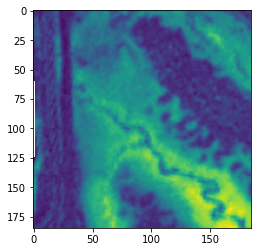

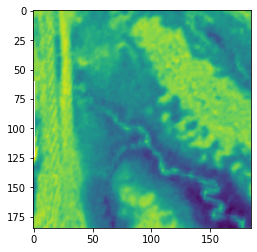

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[1.7808541e-19 1.0000000e+00]
 [1.0000000e+00 9.6865473e-20]
 [6.3923533e-30 1.0000000e+00]
 ...
 [1.0561820e-23 1.0000000e+00]
 [2.3156761e-17 1.0000000e+00]
 [6.4059690e-13 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 15668, 15754
0...10...20...30...40...50...60...70...80...90...100 - done.


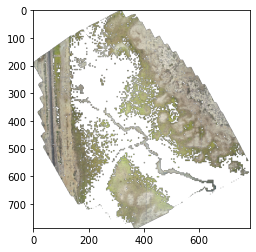

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 15668, 15754
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


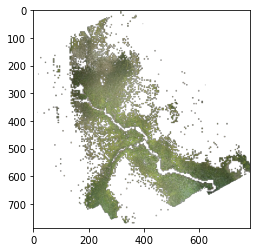

Building vrt and raster...
0...10...20.ERROR 4: content/hr/prob_hr_planetscontent/hr/0/hr_planetscope_085_068.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscontent/hr/0/hr_planetscope_085_068.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_040_076.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_066_055.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_142_104.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_141_151.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planets

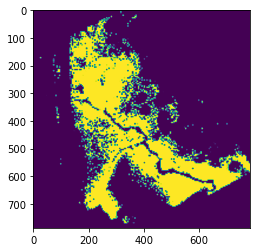

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-07_site08_planetscope_optical.tif
Copying Files


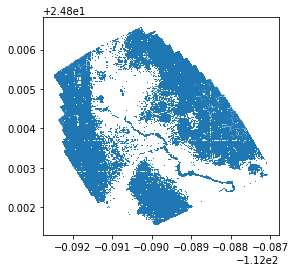

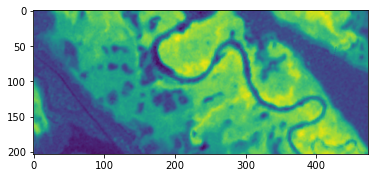

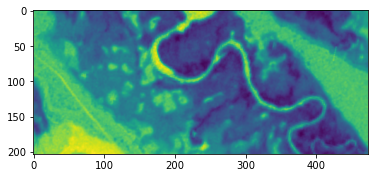

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[4.1502875e-19 1.0000000e+00]
 [1.5097614e-14 1.0000000e+00]
 [1.0000000e+00 4.6283857e-21]
 ...
 [1.0000000e+00 6.1079037e-19]
 [1.0000000e+00 5.1621127e-15]
 [1.0288434e-14 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 41029, 17610
0...10...20...30...40...50...60...70...80...90...100 - done.


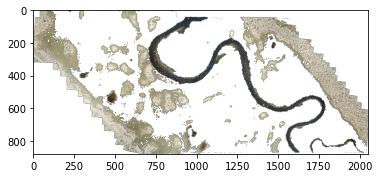

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40769, 17610
0...10...20...30...40...50...60...70...80...90...100 - done.
/bin/bash: /home/e4e/anaconda3/envs/tf-gpu/bin/gdal_merge.py: Argument list too long


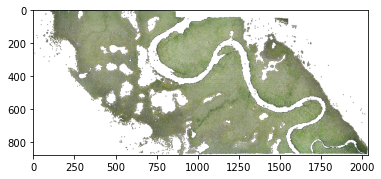

Building vrt and raster...
0...10...20...30...40..ERROR 4: content/hr/prob_hr_planetscope_132_121.ticontent/hr/0/hr_planetscope_053_249.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_132_121.ticontent/hr/0/hr_planetscope_053_249.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_195_449.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_118_275.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_013_249.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_017_110.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, 

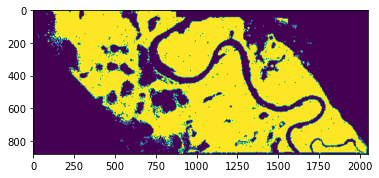

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-05_site09_planetscope_optical.tif
Copying Files


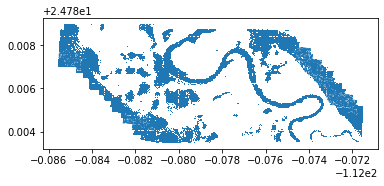

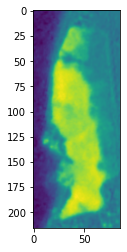

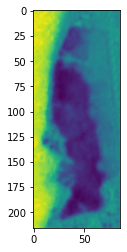

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[2.8728093e-22 1.0000000e+00]
 [1.3043321e-20 1.0000000e+00]
 [1.1512784e-15 1.0000000e+00]
 ...
 [1.0000000e+00 2.1717009e-19]
 [1.0000000e+00 8.0047817e-13]
 [2.6071754e-22 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 7699, 19338
0...10...20...30...40...50...60...70...80...90...100 - done.


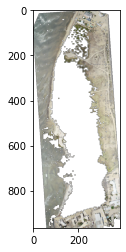

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 7609, 19338
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


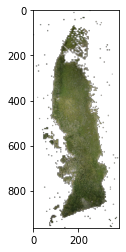

Building vrt and raster...
0...10...20...30ERROR 4: content/hr/prob_hr_planetscope_004_029.tcontent/hr/0/hr_planetscope_202_031.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_004_029.tcontent/hr/0/hr_planetscope_202_031.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_174_048.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_100_063.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_170_038.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_077_050.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. 

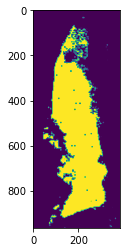

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/lap_2018-07_site04_planetscope_optical.tif
Copying Files


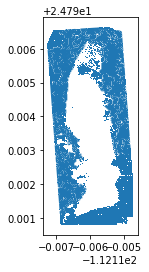

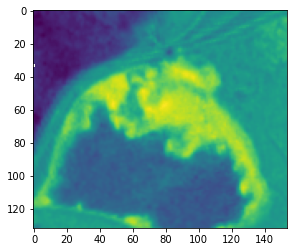

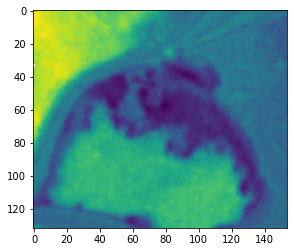

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[1.1357280e-22 1.0000000e+00]
 [5.7566531e-27 1.0000000e+00]
 [1.1730637e-29 1.0000000e+00]
 ...
 [8.7870502e-22 1.0000000e+00]
 [1.7181868e-18 1.0000000e+00]
 [6.3152235e-32 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 13615, 11658
0...10...20...30...40...50...60...70...80...90...100 - done.


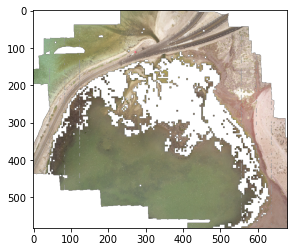

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 11924, 11658
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


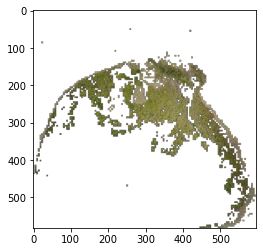

Building vrt and raster...
0...10.ERROR 4: content/hr/prob_hr_planetscope_03content/hr/0/hr_planetscope_042_085.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_03content/hr/0/hr_planetscope_042_085.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_047_037.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_059_071.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_069_087.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_053_052.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/h

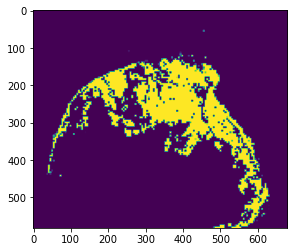

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-05_site11_planetscope_optical.tif
Copying Files


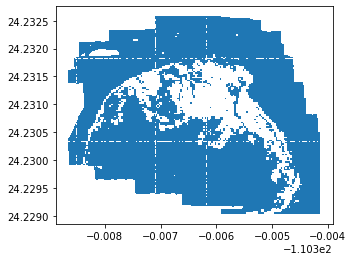

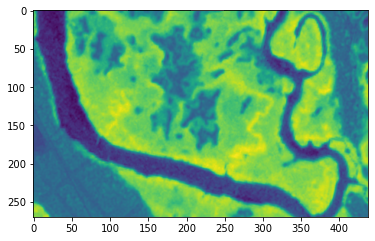

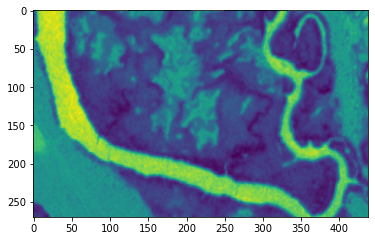

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[9.9130641e-23 1.0000000e+00]
 [1.8187341e-15 1.0000000e+00]
 [1.3167167e-05 9.8342162e-01]
 ...
 [5.8288005e-12 9.9999988e-01]
 [4.1221431e-17 1.0000000e+00]
 [1.0000000e+00 1.2911304e-11]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 38230, 23480
0...10...20...30...40...50...60...70...80...90...100 - done.


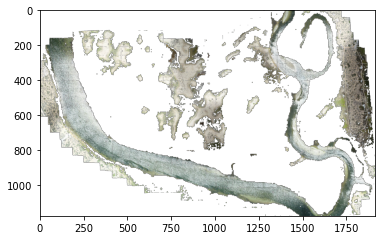

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 38230, 23480
0...10...20...30...40...50...60...70...80...90...100 - done.
/bin/bash: /home/e4e/anaconda3/envs/tf-gpu/bin/gdal_merge.py: Argument list too long


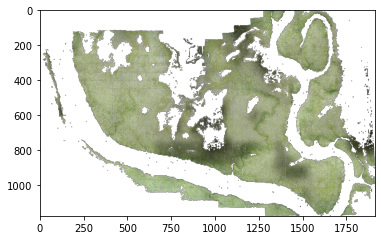

Building vrt and raster...
0...10...20...30...40.ERROR 4: content/hr/prob_hr_planetscope_064_171content/hr/0/hr_planetscope_157_356.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_064_171content/hr/0/hr_planetscope_157_356.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_039_372.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_050_266.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_138_135.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_141_142.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red

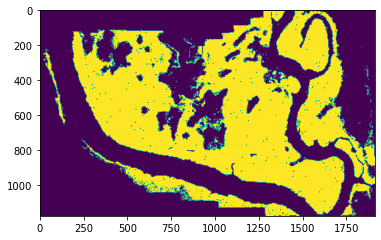

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/lap_2018-07_site06_planetscope_optical.tif
Copying Files


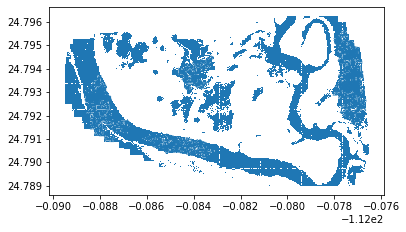

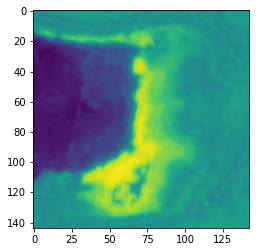

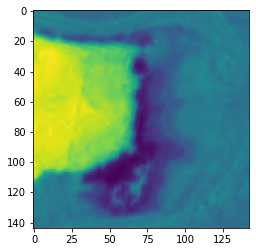

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[8.1733005e-21 1.0000000e+00]
 [7.4392142e-19 1.0000000e+00]
 [7.1400305e-23 1.0000000e+00]
 ...
 [1.0000000e+00 2.4943868e-16]
 [2.3028063e-24 1.0000000e+00]
 [1.3453904e-30 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 12690, 12779
0...10...20...30...40...50...60...70...80...90...100 - done.


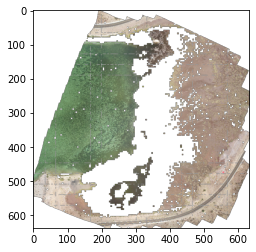

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90..ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
.100 - done.
Input file size is 12602, 12779
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


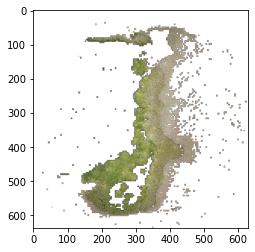

Building vrt and raster...
0...10...ERROR 4: content/hr/prob_hr_planetscope_024_122.ticontent/hr/0/hr_planetscope_105_054.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_024_122.ticontent/hr/0/hr_planetscope_105_054.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_030_105.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_067_111.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_097_059.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_119_076.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipp

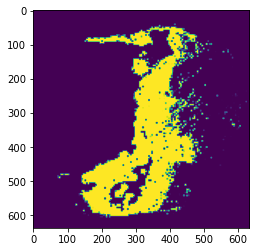

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-05_site12_planetscope_optical.tif
Copying Files


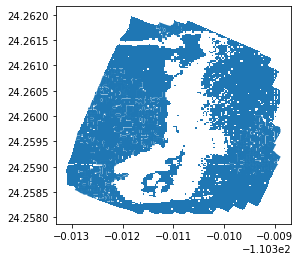

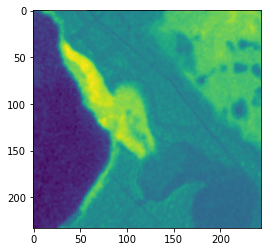

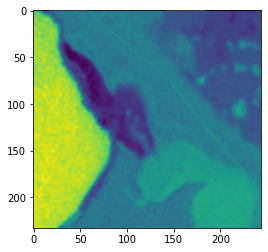

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[3.0554972e-07 9.9988294e-01]
 [3.7953538e-24 1.0000000e+00]
 [2.5805620e-27 1.0000000e+00]
 ...
 [1.7195490e-20 1.0000000e+00]
 [6.1579105e-15 1.0000000e+00]
 [5.6353706e-19 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 22284, 21189
0...10...20...30...40...50...60...70...80...90...100 - done.


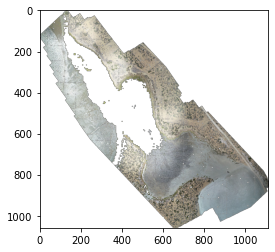

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 22192, 21189
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


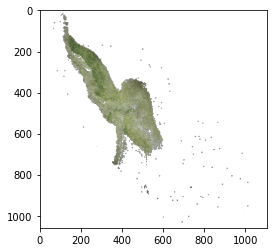

Building vrt and raster...
0...ERROR 4: content/hr/prob_hr_content/hr/0/hr_planetscope_084_069.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_content/hr/0/hr_planetscope_084_069.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_130_094.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_136_109.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_088_081.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_127_118.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_088_075.tif
Warni

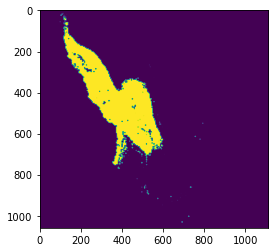

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-05_site8_planetscope_optical.tif
Copying Files


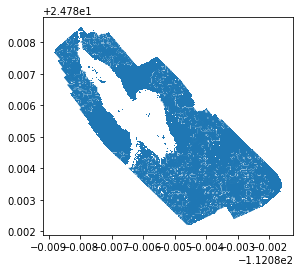

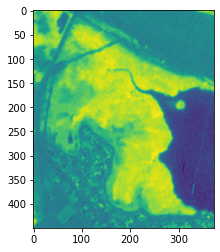

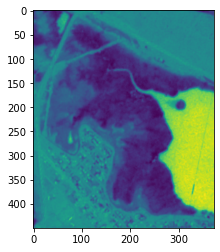

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[9.3045480e-22 1.0000000e+00]
 [1.2720762e-11 9.9999988e-01]
 [1.9523523e-07 9.9885142e-01]
 ...
 [4.9775471e-25 1.0000000e+00]
 [4.6289101e-31 1.0000000e+00]
 [1.0000000e+00 5.4121985e-16]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 31512, 37936
0...10...20...30...40...50...60...70...80...90...100 - done.


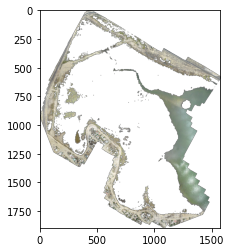

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 31174, 37682
0...10...20...30...40...50...60...70...80...90...100 - done.
/bin/bash: /home/e4e/anaconda3/envs/tf-gpu/bin/gdal_merge.py: Argument list too long


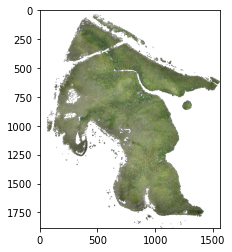

Building vrt and raster...
0...10...20...30..ERROR 4: content/hr/prob_hr_planetcontent/hr/0/hr_planetscope_345_177.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetcontent/hr/0/hr_planetscope_345_177.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_268_167.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_163_113.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_284_190.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_368_205.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_pla

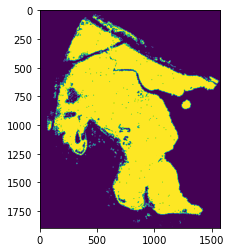

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-05_site01_planetscope_optical.tif
Copying Files


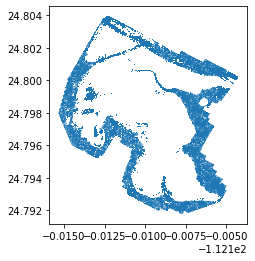

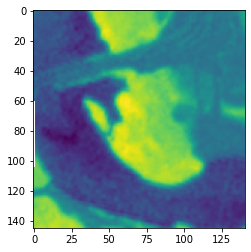

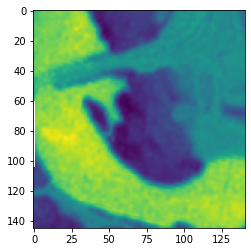

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[9.6074993e-20 1.0000000e+00]
 [1.2493841e-07 9.9979824e-01]
 [6.2157376e-21 1.0000000e+00]
 ...
 [1.4266083e-17 1.0000000e+00]
 [4.1447745e-11 9.9999976e-01]
 [4.3690065e-25 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 12748, 13204
0...10...20...30...40...50...60...70...80...90...100 - done.


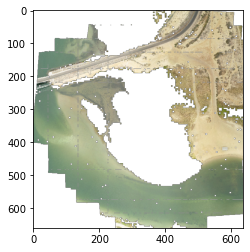

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 12748, 13204
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


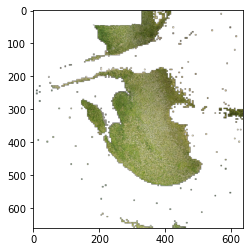

Building vrt and raster...
0...10...20ERROR 4: content/hr/probcontent/hr/0/hr_planetscope_090_085.tif: No such file or directory
Warning 1: Can't open content/hr/probcontent/hr/0/hr_planetscope_090_085.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_052_066.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_024_071.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_040_055.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_115_101.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_013_081.tif
Warnin

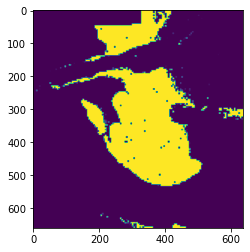

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/skr_2019-05_site04_flight01_planetscope_optical.tif
Copying Files


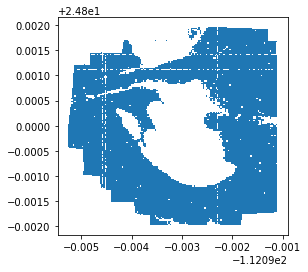

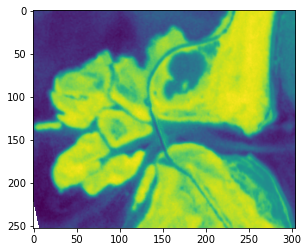

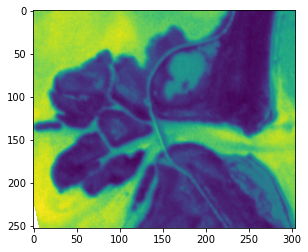

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[6.8210380e-26 1.0000000e+00]
 [2.0100618e-12 1.0000000e+00]
 [1.4539764e-22 1.0000000e+00]
 ...
 [1.0000000e+00 1.9175221e-18]
 [3.1764955e-08 9.9998844e-01]
 [2.8607866e-25 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 27866, 23117
0...10...20...30...40...50...60...70...80...90...100 - done.


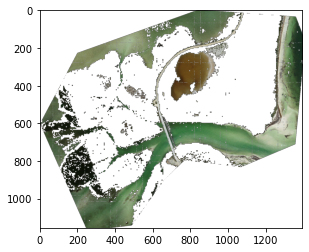

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 27866, 23025
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


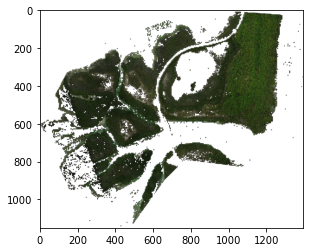

Building vrt and raster...
0...10...20...30.ERROR 4: content/hr/prob_hr_planetscope_103_177content/hr/0/hr_planetscope_087_128.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_103_177content/hr/0/hr_planetscope_087_128.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_113_260.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_094_217.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_050_223.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_131_013.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Ski

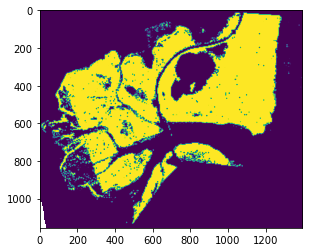

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-07_site09_planetscope_optical.tif
Copying Files


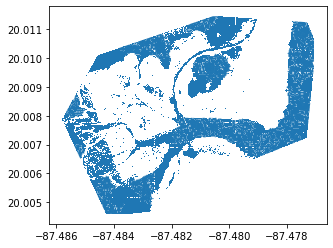

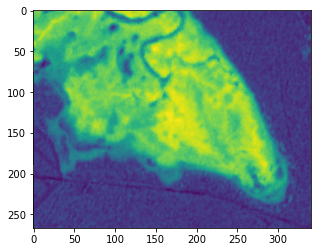

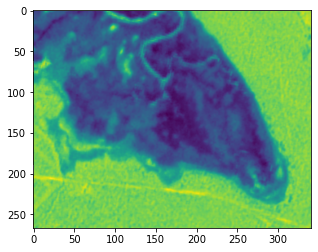

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[1.0000000e+00 6.0663352e-20]
 [1.1616473e-12 1.0000000e+00]
 [2.4138794e-07 9.9155384e-01]
 ...
 [1.0576584e-29 1.0000000e+00]
 [1.0000000e+00 8.3415545e-16]
 [1.0000000e+00 5.0455000e-21]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 29059, 22700
0...10...20...30...40...50...60...70...80...90...100 - done.


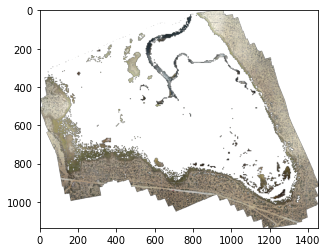

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 28973, 22700
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


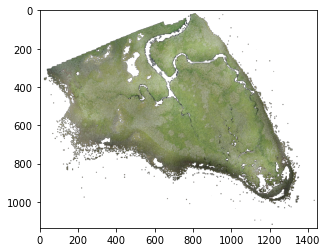

Building vrt and raster...
0...10...20...30...ERROR 4: content/hr/prob_hr_plcontent/hr/0/hr_planetscope_201_282.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_plcontent/hr/0/hr_planetscope_201_282.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_080_138.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_046_142.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_118_231.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_181_214.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscop

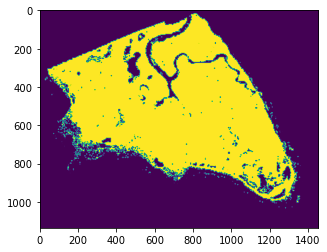

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/lap_2018-07_site05_planetscope_optical.tif
Copying Files


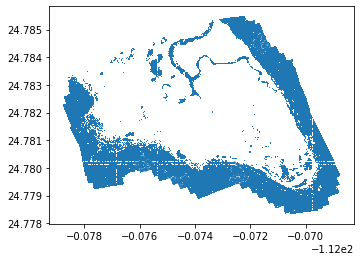

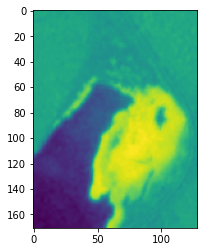

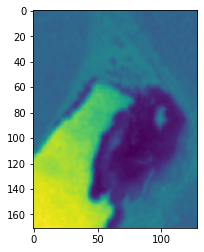

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[4.7633830e-09 9.9998879e-01]
 [2.1550169e-24 1.0000000e+00]
 [6.2028658e-24 1.0000000e+00]
 ...
 [4.3833005e-08 9.9991155e-01]
 [7.6226637e-19 1.0000000e+00]
 [6.8547044e-21 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 12058, 15984
0...10...20...30...40...50...60...70...80...90...100 - done.


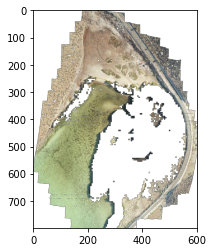

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 12058, 15797
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


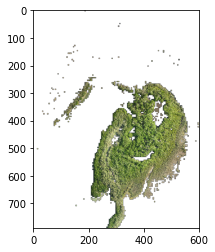

Building vrt and raster...
0...10...20ERROR 4: content/hr/prob_hr_planetscope_1content/hr/0/hr_planetscope_059_091.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscope_1content/hr/0/hr_planetscope_059_091.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_101_099.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_087_108.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_124_102.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_120_099.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0

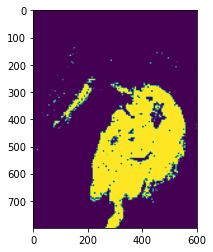

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/lap_2020-05_BahiaFalsa_planetscope_optical.tif
Copying Files


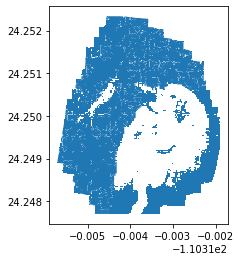

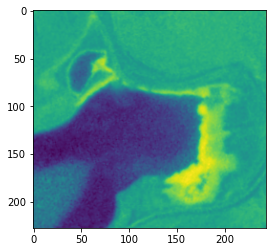

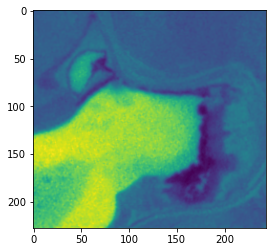

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[1.9464675e-14 1.0000000e+00]
 [2.1182278e-30 1.0000000e+00]
 [1.0000000e+00 1.6603167e-21]
 ...
 [1.1376935e-20 1.0000000e+00]
 [1.3377113e-19 1.0000000e+00]
 [1.0152288e-11 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 22181, 20728
0...10...20...30...40...50...60...70...80...90...100 - done.


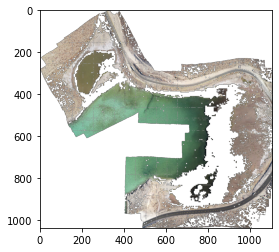

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 22181, 20728
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


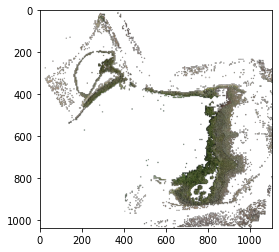

Building vrt and raster...
0...10.ERROR 4: content/hr/prob_hr_placontent/hr/0/hr_planetscope_086_141.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_placontent/hr/0/hr_planetscope_086_141.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_215_184.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_191_146.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_221_174.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_195_150.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_114_182.

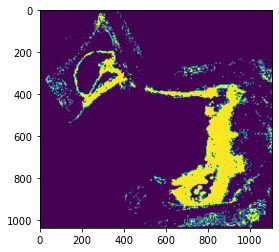

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/psc_2018-05_site13-14_planetscope_optical.tif
Copying Files


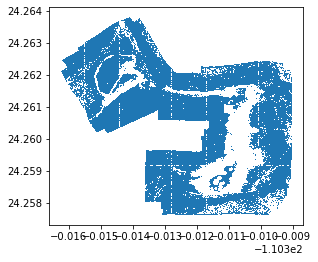

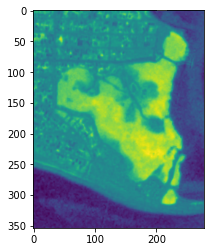

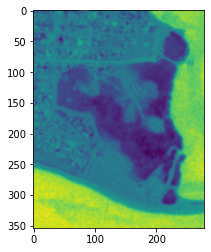

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[1.2932971e-22 1.0000000e+00]
 [2.1278727e-12 1.0000000e+00]
 [2.7459597e-25 1.0000000e+00]
 ...
 [3.8628563e-21 1.0000000e+00]
 [5.1260347e-08 9.9998045e-01]
 [1.2414453e-07 9.9959832e-01]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 24737, 30989
0...10...20...30...40...50...60...70...80...90...100 - done.


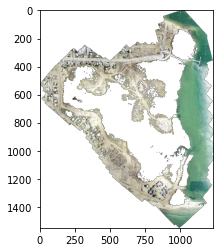

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 24112, 30811
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


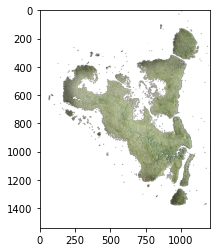

Building vrt and raster...
0...10...ERROR 4: concontent/hr/0/hr_planetscope_098_198.tif: No such file or directory
Warning 1: Can't open concontent/hr/0/hr_planetscope_098_198.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_095_223.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_148_122.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_149_040.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_200_172.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_237_152.tif
Warning 6: gdalbuildvrt does not

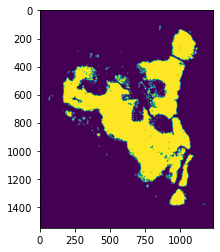

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/lap_2020-04_PuertoGata_planetscope_optical.tif
Copying Files


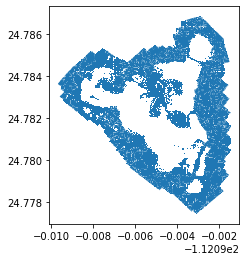

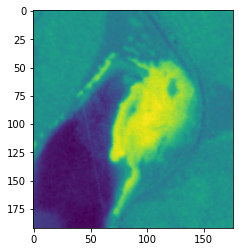

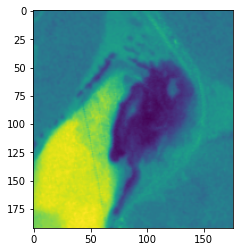

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[6.2534998e-15 1.0000000e+00]
 [5.0005792e-16 1.0000000e+00]
 [1.3711247e-31 1.0000000e+00]
 ...
 [4.0298409e-14 1.0000000e+00]
 [5.4299590e-17 1.0000000e+00]
 [4.1610222e-14 1.0000000e+00]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 16312, 17795
0...10...20...30...40...50...60...70...80...90...100 - done.


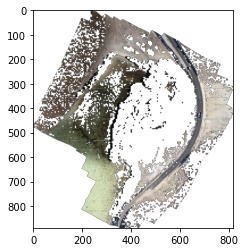

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 16312, 17795
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


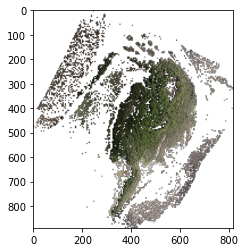

Building vrt and raster...
0...10...20.Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_068_089.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_031_098.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_052_163.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_178_088.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_115_092.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_172_115.tif
Warning 6: gdalbuildvrt does no

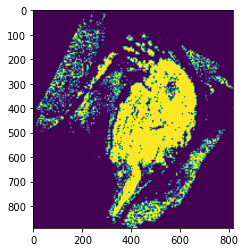

Generating data for:  /home/e4e/mangrove/Dillon/Bulk Processing/lap_2018-07_site01_planetscope_optical.tif
Copying Files


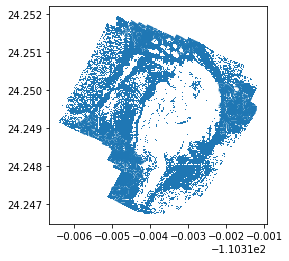

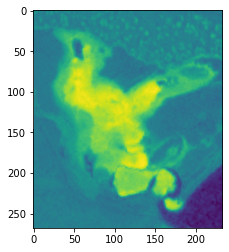

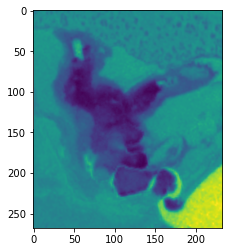

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.



Generating Drone Data


/home/e4e/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



[[1.18459837e-21 1.00000000e+00]
 [6.88798849e-15 1.00000000e+00]
 [1.00000000e+00 3.02467961e-20]
 ...
 [9.44847762e-22 1.00000000e+00]
 [3.24594077e-17 1.00000000e+00]
 [1.39463365e-08 9.99955654e-01]]



Generating tiles for probability plot



Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 21190, 24480
0...10...20...30...40...50...60...70...80...90...100 - done.


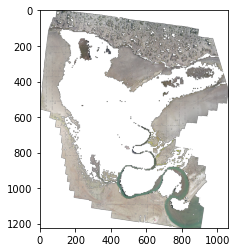

Building vrt and raster...
0...10...20...30...40...50...60...70...80...90...ERROR 4: : No such file or directory
Warning 1: Can't open . Skipping it
100 - done.
Input file size is 20916, 24480
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


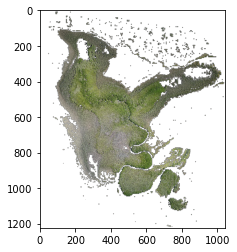

Building vrt and raster...
0...10...20...ERROR 4: content/hr/prob_hr_planetscopcontent/hr/0/hr_planetscope_169_054.tif: No such file or directory
Warning 1: Can't open content/hr/prob_hr_planetscopcontent/hr/0/hr_planetscope_169_054.tif. Skipping it
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_205_170.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_186_099.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_061_088.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr_planetscope_013_077.tif
Warning 6: gdalbuildvrt does not support heterogeneous band color interpretation: expected Gray, got Red. Skipping content/hr/0/hr

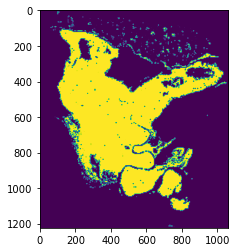

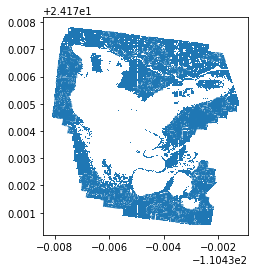

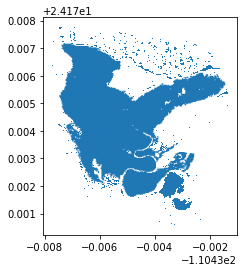

In [24]:
from tensorflow.keras.models import load_model
for site in sites: 
    if not os.path.isdir(site[2]):
        print("Generating data for: ", site[1])

        copy_files(site)

        write_ndvi("content/planetscope.tif")
        #write_vari("planetscope.tif")
        write_ndwi("content/planetscope.tif")

        retile(site)
        gen_drone(site)

        img, meta = raster.load_image("content/planetscope.tif")
        n_bands = img.count


        hr, lr, files = load_images("content/hr", n_bands)

        model = load_model("model")
        results_df = classify(model, files, hr, lr)

        !rm -rf content/0 content/1
        !mkdir content/0 content/1

        generate_probtiles(results_df)
        move_files(results_df)

        create_rasters(site)
        create_polygons(site)